# Imports and settings

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline 
import os.path
import json
import scipy
import argparse
import math
import pickle
import pylab
import cv2
from sklearn.preprocessing import normalize
caffe_root = '/storage/plzen1/home/gogartom/caffe-segnet/'                # Change this to the absolute directoy to SegNet Caffe
import sys
import caffe

import ipywidgets as widgets
from IPython import display as disp 

In [2]:
plt.rcParams['figure.figsize'] = (25, 25)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model = '/storage/plzen1/home/gogartom/TextMaps/models/both_classif_inference.prototxt'
weights = '/storage/plzen1/home/gogartom/TextMaps/models/training/both_classif_iter_6000.caffemodel'
iters = 30

caffe.set_mode_gpu()
net = caffe.Net(model,
                weights,
                caffe.TEST)

KeyError: 'result_scale'

SystemError: NULL result without error in PyObject_Call

In [ ]:
def next_image():
    net.forward()
    
def get_image():
    image = net.blobs['im_data'].data     
    image = np.squeeze(image[0,:,:,:])
    image = image/255.0
    image = np.transpose(image, (1,2,0))
    image = image[:,:,(2,1,0)]
    return image


###--- Displays activations of convolutional layers (incl. pools and norms)
def display_conv_activations(selected_layer, selected_neuron):
    ### clear previous
    disp.clear_output(wait=True)

    ### Get activations 
    layer_activations = net.blobs[selected_layer].data[0]
    
    ### Convert BGR image to RGB
    im = get_image()
    
    im_orig_shape = im.shape

    ### Get activations
    activations = layer_activations[selected_neuron] #135 #169
    
    act_x_ratio =  im.shape[1]/activations.shape[1]
    act_y_ratio =  im.shape[0]/activations.shape[0]
    
    activations = np.kron(activations, np.ones((act_y_ratio,act_x_ratio)))
    
    im_ratio =  activations.shape[1]*1.0/ im.shape[1]
    im = scipy.ndimage.zoom(im, im_ratio, order=0)

    ## DISPLAY
    #-- image
    plt.imshow(im) 
      
    #-- activations
    plt.imshow(activations, alpha=0.6) 
    
def display_results():
    disp.clear_output(wait=True)
    
    image = net.blobs['im_data'].data   #(1, 3, 1280, 1280)
    predicted = net.blobs['prob'].data[:,0:4,0,0]  #(n_boxes,n_classes)
    boxes = net.blobs['boxes'].data[:,1:5]         #(n_boxes, 4)
    price_accuracy = net.blobs['web_price_accuracy'].data
    name_accuracy = net.blobs['web_name_accuracy'].data
    image_accuracy = net.blobs['web_image_accuracy'].data
    
    # get image for plt
    image = np.squeeze(image[0,:,:,:])
    image = image/255.0
    image = np.transpose(image, (1,2,0))
    image = image[:,:,(2,1,0)]

    # show image
    plt.imshow(image,vmin=0, vmax=1)
    
    # get class for each element (n_boxes,)
    box_class = np.argmax(predicted,axis=1)
    # find boxes with highest probability
    max_boxes = np.argmax(predicted,axis=0)
    
    colors = ['r','g','b']
    
    # for each class
    for cls in range(1,4):
        #-- get max box
        ind = max_boxes[cls]
        pred_box = boxes[ind,:]
        
        #-- plot max box
        rect = plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2] - pred_box[0],
                      pred_box[3] - pred_box[1], fill=True, alpha=0.5,facecolor=colors[cls-1],
                             edgecolor=colors[cls-1], linewidth=5)
        plt.gca().add_patch(rect)
        
#         #-- plot other classified boxes
#         #for each box in this class -> plot them
#         for box_ind in np.where(box_class==cls)[0]:
#             box = boxes[box_ind,:]
#             prob = predicted[box_ind,cls]
#             rect = plt.Rectangle((box[0], box[1]), box[2] - box[0],
#                       box[3] - box[1], fill=True, alpha=prob*0.5,facecolor=colors[cls-1],edgecolor="none", linewidth=5)
#             plt.gca().add_patch(rect)
            
        # plot groundtruths
        gt_box = boxes[cls-1]
        # plot max box
        rect = plt.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0],
                      gt_box[3] - gt_box[1], fill=False, edgecolor='black', linewidth=2)
        plt.gca().add_patch(rect)
        
        
#         # plot all boxes
#         for box in boxes:
#             rect = plt.Rectangle((box[0], box[1]), box[2] - box[0],
#                           box[3] - box[1], fill=False, edgecolor='black', linewidth=2)
#             plt.gca().add_patch(rect)
            
    print 'Price:', price_accuracy
    print 'Name:', name_accuracy
    print 'Image:', image_accuracy

Price: [ 1.]
Name: [ 1.]
Image: [ 1.]


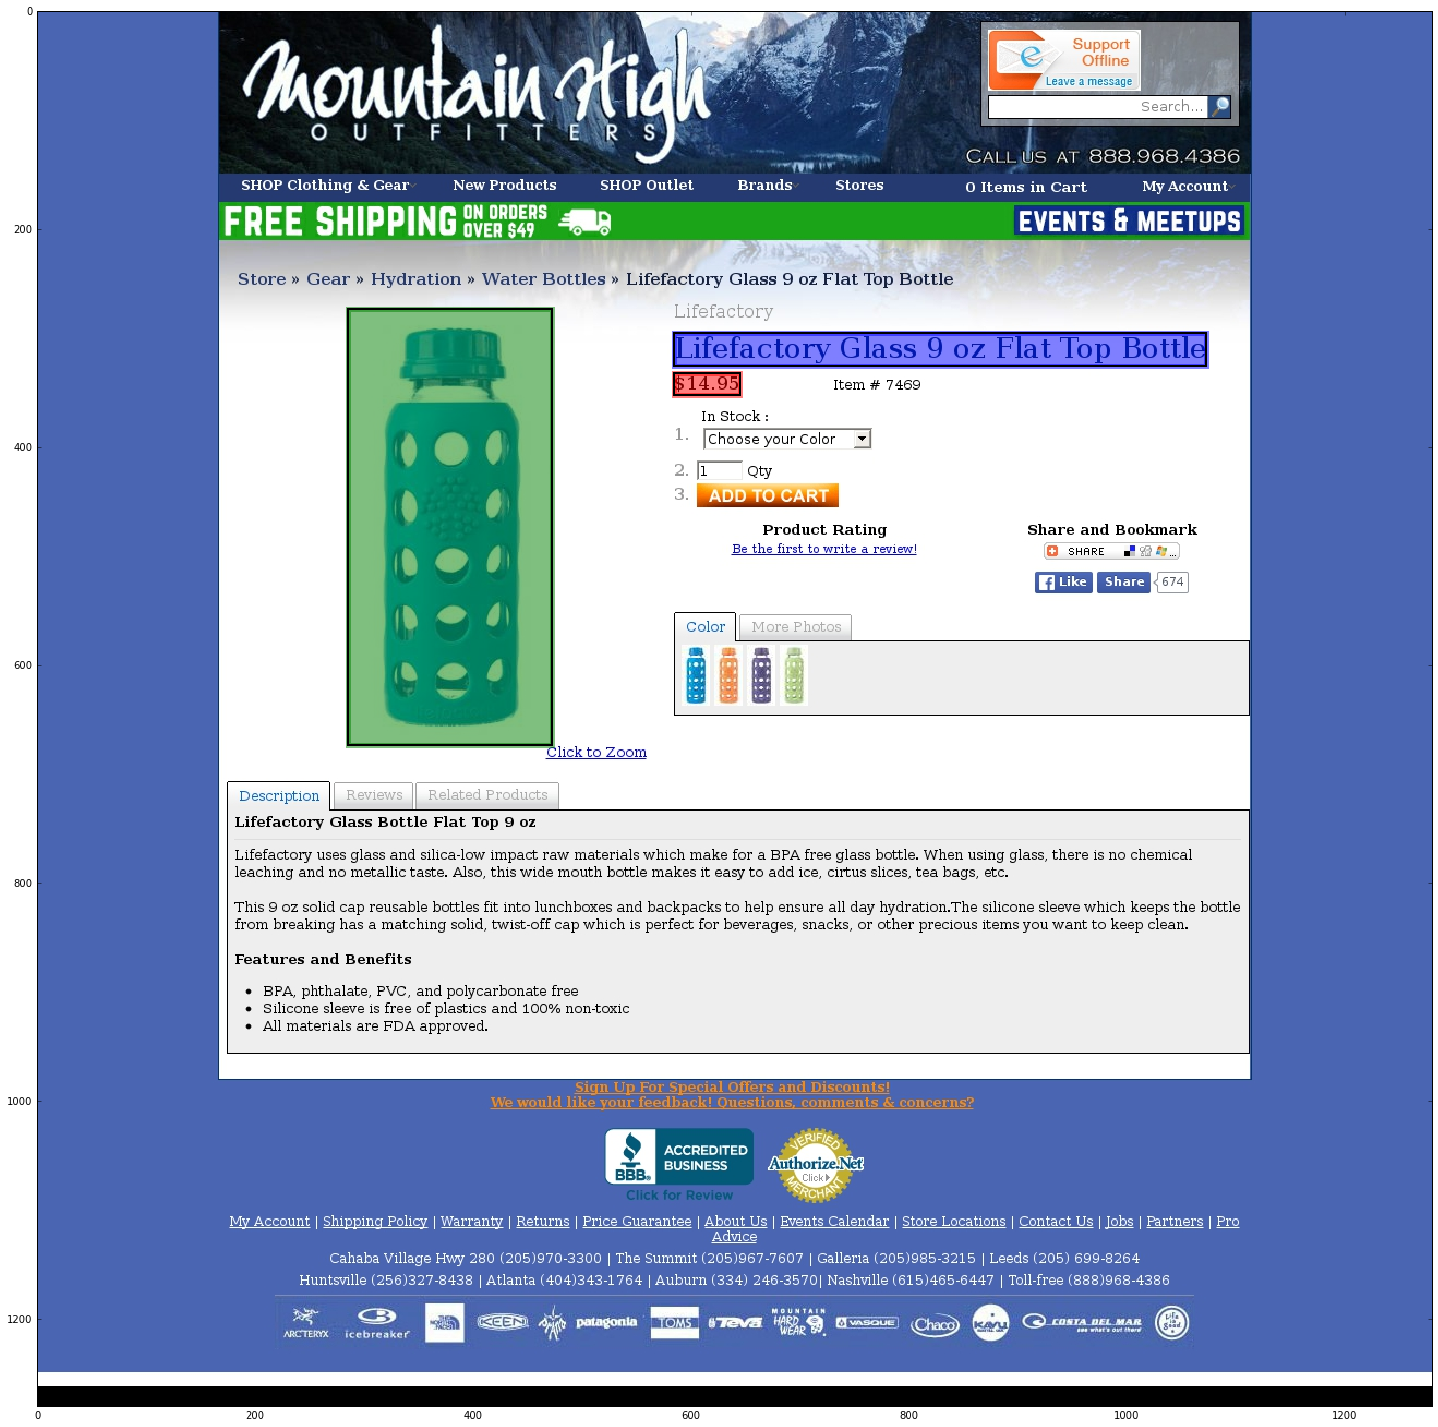

In [6]:
def display_selection():
    selected_layer = layer_selector.value
    selected_neuron = neuron_slider.value
 
    # display convolutions
    display_conv_activations(selected_layer, selected_neuron)

########### LAYER SELECTOR ###########
def handle_layer_change():
    selected_layer = layer_selector.value
    #update neuron slider
    neuron_slider.max = len(net.blobs[selected_layer].data[0])-1 
    #display
    display_selection()

layers_to_select = [layer for layer in net.blobs.keys()] 

layer_selector = widgets.Dropdown(
    options=layers_to_select,
    description='Select layer:',
)

layer_selector.on_trait_change(handle_layer_change, name="value")

######### NEURON SLIDER ###########
def handle_neuron_change():
    display_selection()

neuron_slider = widgets.IntSlider(
    min=0,
    max=len(net.blobs[layer_selector.value].data[0])-1,
    description='Select neuron:',
)

neuron_slider.on_trait_change(handle_neuron_change, name="value")

######### NEXT BUTTON ###########
def click(b):
    next_image()
    display_results()

next_button=widgets.Button(description='Next Image')
next_button.on_click(click)

disp.display()
disp.display(next_button)
disp.display(layer_selector)
disp.display(neuron_slider)
display_results()